### Classifier for determining if text relates to success or failure

The goal of this project is to build a classifier that can determine if an input text describes an instance of success or failure (or neither). It is mainly intended to be used on journal articles, reports and/or interviews, and it has been developed using mainly examples from business and engineering, although it can be applied to other text data as well. I have done an in-depth test using one particular real-world case, which is to analyze the text of an interview with a startup founder and determine whether the startup failed or succeeded.  
This problem resembles sentiment analysis, and I will be using some approaches from sentiment analysis (word embeddings and an LSTM network).

#### Table of contents

This notebook is organized into sections as follows:

1. **Assemble training data** :  
    Here, I assemble a collection of example sentences used to train the classifier.  
    Positive sentences (those describing success) and negative sentences (describing 
   failure) are loaded directly from training data files.  
   Neutral sentences (no clear success or failure) are obtained by downloading Wikipedia articles.
                                
2. **Train the classifier**   :  
In this section, I define this classifier using keras and train it on the training data from 1.  
The classifier consists of an LSTM network which runs on language that has been transformed via a GloVe word embedding.  
I use crossvalidation to estimate how well the classifier can generalize on data drawn from the training distribution.
                                
3. **Brief classifier demo**  :  
I run the trained classifier on some example sentences, as a demonstration
    
4. **Assemble test data**     :  
I use web scraping to gather a dataset of interviews with startup founders from 
www.failory.com. The startups either succeeded or failed, I want to use the 
classifier from 2. to determine what happened.  
4a : I scrape failory.com and download all the relevant articles, then save the raw HTML to an sqllite database. I parse the HTML to extract the text of interest, as well as relevant metadata, and save texts and data to .json  
4b : I visualize some aspects of the failory dataset, including a map showing the locations of all startups in the dataset (via googlemaps API)
                                
5. **Classify test data**     :  
I run the classifier trained in 2. on the failory.com dataset 
    
All intermediate results are saved to file at the end of each section and re-loaded at the start of the next section,
so it is possible to start running the notebook at any section.

#### Setup

The following setup is needed to run this notebook:

- install any required python packages that are not already in your environment (e.g. keras, beautifulsoup4).
    This can be done easily using the "Package Installation" cell below.
- download the GloVe word embedding files from http://nlp.stanford.edu/data/glove.6B.zip, extract and save to a location of your choice. 
    Edit the variable glove_path in the  "Global Settings" cell below to point to your copy of the "300d" .txt file.

In [ ]:
#
#   Package Installation
#

#package installation for jupyter
#if any packages are missing, they can be installed and made available for jupyter 
#by running the code below directly in the notebook (only need to do this once)

#import sys
#!{sys.executable} -m pip install keras
#!{sys.executable} -m pip install beautifulsoup4
#!{sys.executable} -m pip install requests
#!{sys.executable} -m pip install  ...

In [24]:
#
#   Global Settings
#

#some global settings (mostly paths to different files)

glove_path = '/users/cstoneki/Documents/analysis/general_resources/glove.6B/glove.6B.300d.txt'
#path to GLoVe (word embedding) file


max_words_per_sentence = 50
#the maximum number of words any sentence can have, for training or testing
#anything above this gets truncated

### 1. Assemble training data

The first step is to assemble a set of labeled text data for training the classifier. Ultimately, I want to develop  a system that takes single sentences or parts of sentences as input, and returns an estimated probability that the sentence describes an instance of success or failure. I treat this as a 3-class classification problem: the classifier should take text as input, and classify it as positive (describes success), negative (describes failure) or neutral (does not clearly relate to success or failure). Therefore, I need a training dataset consisting of examples from these three classes, with corresponding labels.


To acquire the positive and negative texts (sentences describing success/failure), I manually extracted sentences from a variety of texts. These included descriptions of startups, construction projects, software engineering projects, charitable initiatives, and other instances of success/failure. The websites included Medium, Quora, calleam.com and several others. Using multiple sources is crucial, because it helps to prevent the algorithm from learning any spurious associations between the language style of a sentence and its failure-related status. A full list of sources is given in the files.
I used a simple multiple-alternative scheme to perform data augmentation on some of the sentences. This allows multiple alternatives to be written in curly braces separated by forward slashes, e.g.:

     "{The product/The app} {failed to/did not} {make money/make a profit/generate revenue}"
     
All combinations of the alternatives are then generated, e.g. the above would generate "The product failed to make money" and 11 others.

In [1]:
import os
import time
import re
import sqlite3
import requests
import urllib.request
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import json
import text_combination #this contains code for handling the {a/b/c} method for combining alternatives

In [2]:
#load positive texts (sentences or parts of sentences describing an instance of success)
#these texts are accumulated as keys in a python dict that is written to a file as raw code
#(so it is easy to modify directly)


from training_positive_texts import training_positive_texts
training_positive_texts = list(training_positive_texts.keys())
training_positive_texts = [s2 for s1 in training_positive_texts for s2 in text_combination.get_all(s1)]

In [3]:
print("Number of positive training texts = %d\n\n"%len(training_positive_texts))
#print a few cases at random
print("Examples:\n\n")
_=[print(s + "\n") for s in np.array(training_positive_texts)[np.random.permutation(len(training_positive_texts))[0:5]]]

Number of positive training texts = 2598


Examples:


the team had strong support

we put together a excellent bunch of people

we had a very reliable team

the group kept committed and this was worth it in the end

being successful is tough, but we managed it finally



The negative texts are parts of sentences that describe failure. 

In [12]:
from training_negative_texts import training_negative_texts

training_negative_texts = list(training_negative_texts.keys())
training_negative_texts = [s2 for s1 in training_negative_texts for s2 in text_combination.get_all(s1)]

In [13]:
print("Number of negative training texts = %d\n\n"%len(training_negative_texts))
#print a few cases at random
print("Examples:\n\n")
_=[print(s + "\n") for s in np.array(training_negative_texts)[np.random.permutation(len(training_negative_texts))[0:5]]]

Number of negative training texts = 2683


Examples:


The founders were forced to admit defeat on the project

Non-experts being allowed to make unilateral decisions

She was much too late

She didn't have a sustainable business model

Even worse, no one had enough time to fill the gap



Finally, I need to also train the algorithm with a set of neutral texts, which are sentences/parts of sentences that do not describe failure or success. These clearly belong to a much larger and more diverse set than the positives and negatives. They do need to resemble the positive and negative texts in terms of style and general vocabulary, because if there is any systematic difference the algorithm could learn to exploit this difference, which will ultimately lead to poor performance when it is used on other datasets. To obtain the negative texts, I used several Wikipedia articles on specific software and other projects. I chose articles which did not include extensive discussions of success or failure. The following code downloads these articles, takes the main body of text from each and extracts all sentences. These sentences are used as the neutral texts.

In [14]:
from training_neutral_urls import training_neutral_urls

#download the full text from the specified URLs
#and save it to sqlite database
#reasons: 
#         1) avoid downloading multiple times 
#         2) now have a working snapshot, will not be affected by future wikipedia edits
conn = sqlite3.connect('neutral_text_raw_html.sqlite')
cur = conn.cursor()
cur.execute('CREATE TABLE IF NOT EXISTS Neutral (url TEXT, text TEXT) ')

def insert_neutral_text(cur, url, text):
    cur.execute('SELECT text FROM Neutral WHERE url = ?', (url,))
    #? -> avoid SQL injection
    row = cur.fetchone()
    if(row is None):
        cur.execute('''INSERT INTO Neutral (url, text)
            VALUES (?, ?)''', (url, text))
        return True
    else:
        return False
    
for url in training_neutral_urls.keys():
    print('downloading '+url+'\n')
    article = requests.get(url)
    time.sleep(1)  
    insert_neutral_text(cur, url, article.text)
    conn.commit()

downloading https://en.wikipedia.org/wiki/Linux

downloading https://en.wikipedia.org/wiki/Triborough_Bridge

downloading https://en.wikipedia.org/wiki/Database

downloading https://en.wikipedia.org/wiki/Lean_startup

downloading https://en.wikipedia.org/wiki/Business_model

downloading https://en.wikipedia.org/wiki/Pinterest

downloading https://en.wikipedia.org/wiki/Twitter

downloading https://en.wikipedia.org/wiki/Application_software

downloading https://en.wikipedia.org/wiki/Web_search_engine

downloading https://en.wikipedia.org/wiki/Software

downloading https://en.wikipedia.org/wiki/Project

downloading https://en.wikipedia.org/wiki/Corporation

downloading https://en.wikipedia.org/wiki/Engineering

downloading https://en.wikipedia.org/wiki/Firefox

downloading https://en.wikipedia.org/wiki/User_interface

downloading https://en.wikipedia.org/wiki/Operating_system

downloading https://en.wikipedia.org/wiki/Adobe_Photoshop

downloading https://en.wikipedia.org/wiki/IPad

downlo

In [15]:
#now retrieve the negative article texts from the sqllite database
#accumulate them in a list
sqlstr = 'SELECT text FROM Neutral'
ls = []
for row in cur.execute(sqlstr):
    ls.append(row[0])

In [16]:
#this function cleans Wikipedia text by removing some aspects we do not want
#these are, at the moment:
#   "listen" audiofile links
#   citations
#   (maybe will add others in future)
#it then splits the text into sentences
#it splits on periods within appropriate context, 
#   so it will not split on periods that are part of a number

#  returns: list of sentences (as strings)

def clean_split_wikipedia_text(article_text):

    soup = BeautifulSoup(article_text, "html.parser")
    text = ""
    tags = soup.findAll("p")
    for t in tags:
        text = text + t.text
    #only take contents of <p> tags
    #this ensures we only take the main text while discarding extraneous material 
    #(references etc.)
        
    sentences = re.split('\. |\.\\n|\.\[\d+\]', text)
    #split on: period followed by space | period followed by line break | period followed by citation 

    sentences = [s.split() for s in sentences]
    #split on whitespace
    sentences = [s for s in sentences if len(s) > 2 and len(s) < 50]
    #remove unsually short or long sentences

    remove_citations = lambda s : [t for t in s if "[" not in t and "]" not in t]
    sentences = [remove_citations(s) for s in sentences]
    
    remove_listens = lambda s : [t for t in s if "/" not in t and not t=="(listen)"]
    sentences = [remove_listens(s) for s in sentences]
    
    
    sentences = [" ".join(s) for s in sentences]
    
    return sentences


In [17]:
#apply cleaning and splitting function
training_neutral_texts = []
for t in ls: training_neutral_texts = training_neutral_texts + clean_split_wikipedia_text(t)

In [18]:
#now training_neutral_texts is a list of sentences, so it is directly comparable with training_positive_texts and training_negative_texts

In [19]:
print("Number of neutral training texts = %d\n\n"%len(training_neutral_texts))
#print a few cases at random
print("Examples:\n\n")
#print a few cases at random
_=[print(s + "\n") for s in np.array(training_neutral_texts)[np.random.permutation(len(training_neutral_texts))[0:5]]]

Number of neutral training texts = 5241


Examples:


For example, articles about small towns in the United States might be available only in English, even when they meet notability criteria of other language Wikipedia projects

This is a recent list of the computers which appeared at the top of the TOP500 and the "Peak speed" is given as the "Rmax" rating

Many other types of applications available for Microsoft Windows and macOS also run on Linux

Ickes threatened to withhold salaries for TBA workers as well

There are two remaining reasons to submit a web site or web page to a search engine: to add an entirely new web site without waiting for a search engine to discover it, and to have a web site's record updated after a substantial redesign



In [20]:
#now save all texts to .json
#so we can immediately load them and start at 2. if desired
training_dict = {"negative_texts":training_negative_texts,\
                 "positive_texts":training_positive_texts, "neutral_texts":training_neutral_texts}
with open('training_data.json', 'w') as fp:
    json.dump(training_dict, fp)

### 2. Train the classifier

I want to develop a classifier which takes sentences or parts of sentences as input and returns an estimated probability that this input describes an instance of failure.
My approach is as follows:
First, I use GloVe word embeddings to convert each word of the sentence to a 300-dimensional vector. The idea behind this is that the embeddings should capture some aspects of the meaning of each word, which will enable the classifier to generalize to sentences with similar semantics, even if it has never seen the precise words before. For example, I would hope that once the classifier learns that the sentence "it was a disaster" is an instance of failure, it will subsequently classify "it was a catastrophe" as failure as well, even if the word "catastrophe" never appeared in the training dataset.
Using word embeddings is crucial because I can't realistically assemble a training dataset that includes all combinations of relevant english words, so I need to build a system that can perform semantic generalization.

In [32]:
import LSTM_functions as lstm
#separate file contains functions for defining and training LSTM

import numpy as np
import pandas as pd
import json
import pickle

import importlib


In [33]:
#load the data that we assembled in 1. from .json
with open('training_data.json', 'r') as fp:
    training_data = json.load(fp)


In [34]:
#load GloVe data
#this can take a bit of time, especially for the higher-dimensional datasets (such as 300d)
#so report progress

glove_df = lstm.load_glove(glove_path)

Found 400000 words in glove dataset
Words loaded : 000000 
Words loaded : 050000 
Words loaded : 100000 
Words loaded : 150000 
Words loaded : 200000 
Words loaded : 250000 
Words loaded : 300000 
Words loaded : 350000 
Finished loading data


The model I use is an LSTM, implemented using Keras. The code is in a separate file (LSTM_functions.py)

In [59]:
importlib.reload(lstm)
hp = lstm.get_default_hyperparameters()
#dictionary containing hyperparameters for training
hp['max_words_per_sentence'] = max_words_per_sentence
#max words per sentence to allow
#sentences longer than this are truncated


hp['n_positive'] = 2500#2500
hp['n_negative'] = 2500#2500
hp['n_neutral'] = 5000#5000
#numbers of cases to train on
#the function is supplied with somewhat more cases than this
#it selects the given number of cases at random from the list provided

hp['n_epochs'] = 100#200
#number of epochs = parameter update steps

hp['n_folds'] = 0 
#number of folds for crossvalidation
#if set to a value <= 1: do not perform crossvalidation
#just train on a random selection of data of size given by n_positive etc.
#output predictions are made on training data
#if n_folds >= 2 : perform crossvalidation
#first take a random selection of data of size given by n_positive etc.
#then split into folds, train on n_folds - 1 folds, make predictions on holdout
#then finally train on all folds and return the trained model
#output predictions are made on holdout from crossvalidation


#train_LSTM: 
# inputs are list of positive sentences, list of negative sentences, embedding mapping dataframe, and hyperparameter dictionary (optional)
# outputs are trained model, predictions, true labels, and list of sentences actually used for training
# (depending on hyperparameters, may not use all the training data provided)
#the model is always trained on a dataset of size given by n_positive etc.
#the predictions are made using crossvalidation if n_folds >= 2, otherwise they are
#simply the output of the model on its training data

(model_data, out_of_fold_preds, labels, training_cases) = lstm.train_LSTM(training_data['positive_texts'], training_data['negative_texts'], training_data['neutral_texts'], glove_df,hp=hp)


Epoch 1/100
10000/10000 [==============================] - 30s 3ms/step - loss: 1.0537 - acc: 0.4945
Epoch 2/100
10000/10000 [==============================] - 29s 3ms/step - loss: 1.0451 - acc: 0.5000
Epoch 3/100
10000/10000 [==============================] - 29s 3ms/step - loss: 0.7992 - acc: 0.6297
Epoch 4/100
10000/10000 [==============================] - 29s 3ms/step - loss: 0.2402 - acc: 0.9232
Epoch 5/100
10000/10000 [==============================] - 32s 3ms/step - loss: 0.1456 - acc: 0.9519
Epoch 6/100
10000/10000 [==============================] - 60s 6ms/step - loss: 0.1137 - acc: 0.9617
Epoch 7/100
10000/10000 [==============================] - 78s 8ms/step - loss: 0.0999 - acc: 0.9693
Epoch 8/100
10000/10000 [==============================] - 46s 5ms/step - loss: 0.0828 - acc: 0.9762
Epoch 9/100
10000/10000 [==============================] - 48s 5ms/step - loss: 0.0720 - acc: 0.9798
Epoch 10/100
10000/10000 [==============================] - 45s 5ms/step - loss: 0.0738 - a

10000/10000 [==============================] - 31s 3ms/step - loss: 0.0018 - acc: 0.9993
Epoch 81/100
10000/10000 [==============================] - 31s 3ms/step - loss: 1.3046e-04 - acc: 1.0000
Epoch 82/100
10000/10000 [==============================] - 31s 3ms/step - loss: 0.0027 - acc: 0.9992
Epoch 83/100
10000/10000 [==============================] - 31s 3ms/step - loss: 3.0475e-04 - acc: 0.9999
Epoch 84/100
10000/10000 [==============================] - 30s 3ms/step - loss: 0.0030 - acc: 0.9993
Epoch 85/100
10000/10000 [==============================] - 30s 3ms/step - loss: 0.0066 - acc: 0.9980
Epoch 86/100
10000/10000 [==============================] - 30s 3ms/step - loss: 7.5050e-04 - acc: 0.9998
Epoch 87/100
10000/10000 [==============================] - 30s 3ms/step - loss: 1.1766e-04 - acc: 1.0000
Epoch 88/100
10000/10000 [==============================] - 31s 3ms/step - loss: 0.0015 - acc: 0.9998
Epoch 89/100
10000/10000 [==============================] - 31s 3ms/step - loss

In [60]:
model_accuracy = np.mean(np.argmax(out_of_fold_preds, axis=1)==labels)
baseline_guessing_accuracy = max(np.mean(labels==0), np.mean(labels==1), np.mean(labels==2))
print("Accuracy of model          = %3f"%model_accuracy)
print("Baseline guessing accuracy = %3f"%baseline_guessing_accuracy)

Accuracy of model          = 1.000000
Baseline guessing accuracy = 0.500000


The out-of-fold accuracy is substantially greater than the baseline guessing accuracy, so the model can learn to generalize well for data drawn from the training distribution. The next step is to try to use the model to solve an actual prediction problem, using data that are drawn from a different distribution.

Finally, save the model data to a file, so we can use it at any time later.
Model data is a dict including the model itself, and some extra data (max_len) needed for making predictions.

In [61]:
pickle.dump( model_data, open( "trained_LSTM_model.p", "wb" ) )

### 3. Demonstrate classifier output

In [ ]:
This section is just a brief demonstration of the output of the classifier for a few example input sentences.

In [112]:
trained_model = pickle.load( open( "trained_LSTM_model.p", "rb" ) )

In [124]:
lstm.predict_LSTM(trained_model, ["Project XYZ was awful"], glove_df)

array([[9.9986088e-01, 1.3831687e-04, 7.8956140e-07]], dtype=float32)

In [125]:
lstm.predict_LSTM(trained_model, ["Project XYZ was successful"], glove_df)

array([[2.3607848e-02, 9.7590691e-01, 4.8524840e-04]], dtype=float32)

### 4. Assemble test data

As an interesting real-world problem, I want to take a set of interviews with startup founders and determine whether the startup failed or succeeded. The interviews are collected at www.failory.com. This is a potentially challenging problem because it requires the model to deal with the semantics of the text. There are no obvious shortcuts: the interview questions are similar or identical for both failure and success, and the overall language use and vocabulary are similar in both cases.

First, we have to gather the data from failory, using web scraping.

In [24]:
import json

#### 4a. Gather Failory data using web scraping

In [25]:
main_urls = {'failory failure':'https://www.failory.com/interview-failure',
             'failory success':'https://www.failory.com/interview-success'}

The downloaded HTML will be stored to an sqlite database, I set this up here: 

In [26]:
conn = sqlite3.connect('failory_data.sqlite')
cur = conn.cursor()
cur.execute('CREATE TABLE IF NOT EXISTS Startups (url TEXT, text TEXT, tags TEXT) ')

In [27]:
def insert_report(cur,  url, text, tags):
    cur.execute('SELECT text FROM Startups WHERE url = ?', (url,))
    #? -> avoid SQL injection
    row = cur.fetchone()
    if(row is None):
        cur.execute('''INSERT INTO Startups (url, text, tags)
            VALUES (?, ?, ?)''', (url, text, tags))
        return True
    else:
        return False

In the cell below, I access each of the main urls defined above. Each of these pages has a list of links to articles about individual startups. I download all of these, and save the raw HTML to the sqlite database.

In [28]:
for tags, url in main_urls.items():
    print('\ncollecting articles from '+url+'\n')
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    a_tags = soup.findAll('a')
    sub_urls = []
    for i in range(len(a_tags)):
        try:
            if(a_tags[i]["class"][0] =='card-for-interviews-title'):
                sub_urls.append(a_tags[i]["href"])
        except:
            continue
    for sub_url in sub_urls:
        full_url = 'https://www.failory.com' + sub_url
        article  = requests.get(full_url)
        print('downloaded '+full_url)
        time.sleep(1)
        
        insert_report(cur, full_url, article.text, tags)
        conn.commit()


collecting articles from https://www.failory.com/interview-failure

downloaded https://www.failory.com/interview/mongoose-cricket
downloaded https://www.failory.com/interview/140-canvas
downloaded https://www.failory.com/interview/singulution
downloaded https://www.failory.com/interview/nox
downloaded https://www.failory.com/interview/wedmap
downloaded https://www.failory.com/interview/profitabilly
downloaded https://www.failory.com/interview/tailor
downloaded https://www.failory.com/interview/hubrif
downloaded https://www.failory.com/interview/repitchbook
downloaded https://www.failory.com/interview/lieferoo
downloaded https://www.failory.com/interview/tandem-app
downloaded https://www.failory.com/interview/twitch-highlights
downloaded https://www.failory.com/interview/wantremotejob
downloaded https://www.failory.com/interview/jobridge
downloaded https://www.failory.com/interview/notezilla
downloaded https://www.failory.com/interview/haptly
downloaded https://www.failory.com/intervie

In [29]:
#print text of first article
sqlstr = 'SELECT url, text, tags FROM Startups'
for k, row in enumerate(cur.execute(sqlstr)):
    if(k > 0): break
    soup = BeautifulSoup(row[1], "html.parser")
    print(soup)

<!DOCTYPE html>
<!-- Last Published: Wed Sep 04 2019 01:06:38 GMT+0000 (UTC) --><html data-wf-domain="www.failory.com" data-wf-page="5aac45db682f563eb2c4aeae" data-wf-site="5966ea9a9217ca534caf139f" lang="en"><head><meta charset="utf-8"/><title>Mongoose Cricket: Shutting down after investing +$130K in glitzy marketing</title><meta content="In 2009, Thomas Evans began working alongside Marcus, the creator of a radical new cricket bat named the Mongoose. After spending over $130,000 on glitzy marketing, and failing to break through the heavily traditional cricket market, they were forced to shut down." name="description"/><meta content="Mongoose Cricket: Shutting down after investing +$130K in glitzy marketing" property="og:title"/><meta content="In 2009, Thomas Evans began working alongside Marcus, the creator of a radical new cricket bat named the Mongoose. After spending over $130,000 on glitzy marketing, and failing to break through the heavily traditional cricket market, they were f

Now we need to figure out how to extract the text of the article from the mess of HTML. We need to strip out all of the ads and repeated quotes. The texts we want to isolate are: the interviewer's questions, and the responses that follow. There are also some tags that the website's editors put at the start of each article, giving the startup's home country, area, and reasons for failure. We want to extract those as well.

In [30]:
#read entire sqllite database into a list of dicts
database_dict_list = []
sqlstr = 'SELECT url, text, tags FROM Startups'
for row in cur.execute(sqlstr):
    entry = {}
    entry['url'] = row[0]
    entry['text'] = row[1]
    entry['tags'] = row[2]
    database_dict_list.append(entry)

In [31]:
#failory has tags at the start of each article
#these are: location, area, failure cause #1, failure cause #2
#these are obviously extremely useful, so we want to extract them
def get_failory_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    article_tags = []
    div_tags = soup.findAll('div')
    for i in range(len(div_tags)):
        try:
            if(div_tags[i]["class"][0] =="secondary-tag-interview"):
                if(div_tags[i].text):
                    article_tags.append(div_tags[i].text)
        except:
            continue
    return article_tags

for entry in database_dict_list:
    if('failory' in entry['tags']):
        #the following will only work for failory articles
        #so check because we may have non-failory articles in database later
        entry['failory_tags'] = get_failory_tags(entry['text'])

In [32]:
#now extract text of interest: the interviewer's questions and the startup founder's responses
def get_questions_responses(text):

    soup = BeautifulSoup(text, "html.parser")
    tags = soup.findAll(['h4', 'p'])
    tags_clean = []
    for i in range(len(tags)):
        try:
            if(tags[i]["class"][0]):
                continue
        except:
            tags_clean.append(tags[i])
        
    questions = []
    responses = []
    current_text = []
    current_question = ""
    for i in range(len(tags_clean)):
        if(tags_clean[i].name=='h4'):
            if(current_question):
                questions.append(current_question)
                responses.append(" ".join(current_text))
            current_question = tags_clean[i].text
            current_text = []
        else:
            current_text.append(tags_clean[i].text)
            
    return (questions, responses)
        
for entry in database_dict_list:
    q,r = get_questions_responses(entry['text'])
    entry['questions'] = q
    entry['responses'] = r

Now, for convenience, I want to save the data that I just processed. I'll use json rather than sql a) because it's much easier to handle fields that are lists of variable length and b) because I am not growing the data entry-by-entry, but dumping a single finished database.

In [33]:
with open('failory_data.json', 'w') as fp:
    json.dump(database_dict_list, fp)

#### 4b Plot a world map showing the locations of all startups

This is a bit of data visualization that is not essential for the classification analysis, but is still interesting for better understanding the scope of the failory dataset.
www.failory.com has interviews with startup founders from a variety of countries. To visualize this better, let's show a world map, in which we plot the number of startups per country.

In [ ]:
googlemaps_api_key = "not a valid key"

In [55]:
#load data fron .json so we can run this separately from rest of notebook
with open('failory_data.json', 'r') as fp:
    data = json.load(fp)

In [ ]:
country_list = [entry['failory_tags'][0] for entry in database_dict_list if 'failory_tags' in entry]
#list containing country of origin for each startup

In [ ]:
print(set(country_list))

In [ ]:

import pandas as pd
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="startup-analysis")

#get geographic coordinates for each country
#these are the geographic centers
locations = []
scales = []
for c in list(set(country_list)):
    
    location = geolocator.geocode(c)
    scales.append(int(np.sum(np.array(country_list)==c)))
    entry = {}
    entry['latitude'] = location.latitude
    entry['longitude'] = location.longitude
    locations.append(entry)
locations = pd.DataFrame(locations)

In [ ]:
scales_to_plot = [int(np.floor(1.5*np.sqrt(s) + 0.5)) for s in scales]
#make scale (diameter of a point) proportional to square root of number of startups
#so the area of a dot is proportional to number of startups

In [ ]:
import gmaps
gmaps.configure(api_key=googlemaps_api_key)
coordinates = (30, 0)
fig = gmaps.figure(center=coordinates, zoom_level=2, layout={'width': '1000px', 'height': '600px'})


startup_layer = gmaps.symbol_layer(
    locations, fill_color='blue', stroke_color='blue', scale = scales_to_plot
)
fig.add_layer(startup_layer)
fig

In [53]:
#display a previously saved image
#this can be useful if googlemaps has API key issues
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(20,10))
img=mpimg.imread('map.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'map.png'

We can also plot a bar chart showing the frequencies of the different failure reasons that were determined by failory:

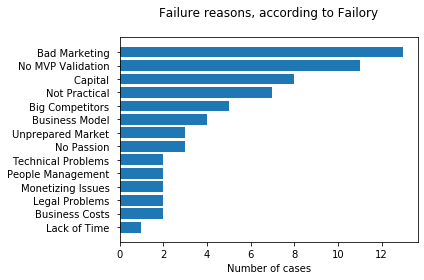

In [59]:
import numpy as np
failure_reason_tags = []
area_tags = []

for d in data:
    
    if('failure' in d['tags'].split()):
        failure_reason_tags = failure_reason_tags + d['failory_tags'][2:3]
        
failure_reason_tags = np.array(failure_reason_tags)
unique_failure_reasons = np.unique(failure_reason_tags)
counts = np.array([np.sum(failure_reason_tags==r) for r in unique_failure_reasons])
order = np.argsort(counts)
counts = counts[order]
labels = unique_failure_reasons[order]
vals = np.arange(len(counts))
plt.barh(vals,counts)
plt.yticks(vals, [lab + " " for lab in labels])
plt.title('Failure reasons, according to Failory\n')
plt.xlabel('Number of cases')
plt.tight_layout()
plt.show()

### 5. Classify test data

In part 4a I scraped www.failory.com to gather a dataset of interviews with startup founders. I had to do some processing to convert raw html to usable text (also in part 4a). Now the text data are stored in a .json file and I can more-or-less directly input these to the LSTM classifier which was trained in part 2.

In [38]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
import re

import LSTM_functions as lstm
#separate file contains functions for defining and training lstm

import numpy as np
import pandas as pd
import json
import pickle

import importlib



In [39]:
with open('failory_data.json', 'r') as fp:
    data = json.load(fp)

In [62]:
trained_model = pickle.load( open( "trained_LSTM_model.p", "rb" ) )

In [63]:
#if we do not have glove data in memory, load it again
importlib.reload(lstm)
try:
    glove_df
except:
    glove_df = lstm.load_glove(glove_path)

In [41]:
def clean_string(s):
    s = s.replace("â", "'")
    return s

def clean_text(data):
    #data text needs some additional cleaning
    for d in data:
        for k in range(len(d["questions"])):
            d["questions"][k] = clean_string(d["questions"][k])
        for k in range(len(d["responses"])):
            d["responses"][k] = clean_string(d["responses"][k])

In [42]:
clean_text(data)

In [43]:
#data is a list of dictionaries
#these have the following entries:
#url - url of original article
#text - original raw text
#tags - tags added by me, single string, space-delimited
#       at the moment, the tags can be either "failory failure" or "failory success"
#       if I add articles from other sources in the future, this will be reflected in the tags
#failory_tags - tags provided by failory, list of strings
#       [country of origin, domain, failure reason 1, failure reason 2]
#questions - list of strings, each is text of a question
#responses - list of strings, each is text of a response
n = 0
print(data[n]["questions"][0])
print(data[n]["responses"][0])

Hi Tom! What's your background, and what are you currently working on?
Hey all! My name is Thomas Evans, I'm 28 and based in London. I've worked my way through a number of startups, the majority successful with one notable failure, to a point where I now find myself at EmailOctopus, an email marketing platform, as COO. That notable failure was Mongoose, a sports equipment manufacturer, which was most widely known for its introduction of a radical new cricket bat in 2009. At Mongoose I managed the production and distribution of those bats, sourcing the bats from contracted manufacturers in Sussex, Huntingdon and a place called Meerut in India. The business model was relatively simple, initially launching as a direct-to-consumer brand in 2009 selling via our website, before moving into retailers in 2010. We were mostly widely known for sponsoring Matthew Hayden during the Indian Premier League. '


In [85]:
#run model on all the responses in failory interviews, from both failures and successes
importlib.reload(lstm)
failure_class = []
preds = []
sentences = []
for d in data:
    sentences_single_article = []
    for r in d["responses"]:
        sentences_single_article = sentences_single_article + r.split(".")

    sentences.append(sentences_single_article)
    
    failure_class.append("failure" in d["tags"])
    preds.append(lstm.predict_LSTM(trained_model, sentences_single_article, glove_df))
    
success_class = np.logical_not(failure_class)

#now preds is a list of arrays, one array per article 
#(an article is the text of the responses in an interview with a startup founder)
#each array is m x 3, where m is number of sentences in the article, 
#and 3 columns correspond to positive, negative and neutral classes

In [94]:
#now get a summary score across all sentences from a given article
#simply by taking the mean probability for each class, over all sentences
sentence_mean = np.array([np.mean(p, axis=0) for p in preds])

In [93]:
#print mean +- SEM of the summary score
print("Summary score for failure:")
print("Mean score from failed startup interviews     = %.3f +/- %.3f"%\
      (np.mean(sentence_mean[failure_class,1]), np.std(sentence_mean[failure_class,1])/np.sqrt(np.sum(failure_class))))
print("Mean score from successful startup interviews = %.3f +/- %.3f"%\
      (np.mean(sentence_mean[success_class,1]), np.std(sentence_mean[success_class,1])/np.sqrt(np.sum(success_class))))
print("\n\n")
print("Summary score for success:")
print("Mean score from failed startup interviews     = %.3f +/- %.3f"%\
      (np.mean(sentence_mean[failure_class,0]), np.std(sentence_mean[failure_class,0])/np.sqrt(np.sum(failure_class))))
print("Mean score from successful startup interviews = %.3f +/- %.3f"%\
      (np.mean(sentence_mean[success_class,0]), np.std(sentence_mean[success_class,0])/np.sqrt(np.sum(success_class))))

Summary score for failure:
Mean score from failed startup interviews     = 0.414 +/- 0.010
Mean score from successful startup interviews = 0.363 +/- 0.012



Summary score for success:
Mean score from failed startup interviews     = 0.067 +/- 0.005
Mean score from successful startup interviews = 0.077 +/- 0.005


So the failed startups have larger summary scores for failure than the successful startups, on average. The same is true for successful startups and the summary scores for success, but the effect is much smller.

In [127]:
def plot_summary_score(score, success_class, failure_class):

    n_bins = 25

    h_class_fail_score_succ, bin_edges = np.histogram(score[failure_class, 0],\
                                              bins = np.linspace(0, np.max(sentence_mean[:,0]), n_bins))
    h_class_fail_score_fail, bin_edges = np.histogram(score[failure_class, 1],\
                                              bins = np.linspace(0, np.max(sentence_mean[:,1]), n_bins))
    h_class_succ_score_succ, bin_edges = np.histogram(score[success_class, 0],\
                                              bins = np.linspace(0, np.max(sentence_mean[:,0]), n_bins))
    h_class_succ_score_fail, bin_edges = np.histogram(score[success_class, 1],\
                                              bins = np.linspace(0, np.max(sentence_mean[:,1]), n_bins))

    bin_width = np.mean(bin_edges[1:] - bin_edges[:-1])
    
    fig, axes = plt.subplots(nrows = 2, ncols = 2)
    
    plt.rcParams["figure.figsize"] = [9,7]

    plt.sca(axes[0,0])
    plt.title("Failure score")  
    plt.bar(bin_edges[:-1], h_class_fail_score_fail, width=bin_width, align='edge', color=[1, 0.1, 0.1], alpha=0.75, label='class = failure')
    plt.ylim([0, 12])
    plt.ylabel('Count')
    plt.legend()
    plt.sca(axes[1,0])
    plt.bar(bin_edges[:-1], h_class_succ_score_fail, width=bin_width, align='edge', color=[0.1, 1, 0.2], alpha=0.75, label='class = success')
    plt.ylim([0, 12])
    plt.ylabel('Count')
    plt.legend()
    plt.sca(axes[0,1])
    plt.title("Success score")  
    plt.bar(bin_edges[:-1], h_class_fail_score_succ, width=bin_width, align='edge', color=[1, 0.1, 0.1], alpha=0.75, label='class = failure')
    plt.ylim([0, 12])
    plt.legend()
    plt.sca(axes[1,1])
    plt.bar(bin_edges[:-1], h_class_succ_score_succ, width=bin_width, align='edge', color=[0.1, 1, 0.2], alpha=0.75, label='class = success')
    plt.ylim([0, 12])
    plt.legend()
    plt.show()

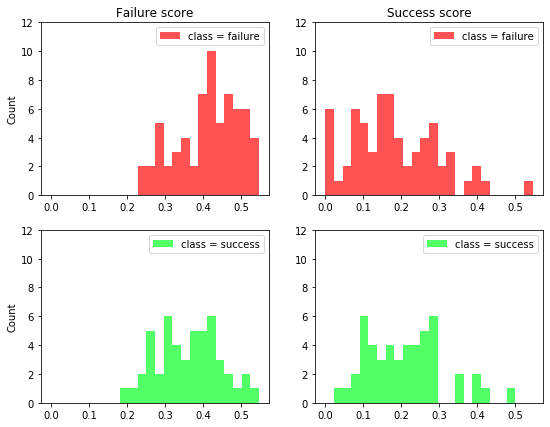

In [128]:
plot_summary_score(sentence_mean, success_class, failure_class)

This plot shows that the distributions of scores are quite spread out, and overlap substantially between failed and successful startups. So even though the failed startups have a greater mean failure score than the successful startups, attempting to classify individual startups based on the scores will still have a high error rate.

In [107]:
print(sum(failure_class))
print(sum(success_class))

65
49


In [74]:
#now for each article, we have a list of predictions, 1 per sentence
#print some of the sentences with strongest/weakest predictions for failure

article_ind = 30

success_prob = preds[article_ind][:,0]
failure_prob = preds[article_ind][:,1]
neutral_prob = preds[article_ind][:,2]
#/np.max(preds[article_ind][:,0], preds[article_ind][:,0])

normalized_score_failure = (failure_prob - success_prob) /neutral_prob

normalized_score_success = (success_prob - failure_prob) / neutral_prob

failure_order = np.argsort(normalized_score_failure)[::-1]
success_order = np.argsort(normalized_score_success)[::-1]

print("highest scoring for failure:")
ind_top = failure_order[:5]
for i in ind_top:
    print(sentences[article_ind][i])
    

highest scoring for failure:
 But being a developer, it's really easy to get caught up in assuming you know what users want and escaping to our comfort zones: a text editor and terminals ;) As for our business model, it was similar to payment processors where we take a percentage of each gym membership payment transaction made between the gym and the client
 I definitely took the lessons from Gymlisted and learned what not to do! '
Here's what I thought about and learned during the 8 months spent building Gymlisted: 1) You should build the simplest version of your idea and validate early on - We mistakenly thought that getting the 'okay' from one person meant that was enough to justify building out a full-on website/product
 Back in early 2017, I partnered up with a friend of mine to start a startup that ultimately failed called Gymlisted
 So, I decided to buy a 360 Camera and offer free 360 photos and videos to the gym owners so they could use it on Gymlisted and anywhere el

Conclusion: the classifier based on GLoVe embedding + LSTM network performs reasonably well. The performance could definitely be increased by increasing the training set size. I used a training set with a total of 10000 sentences, split between 2000 positive (descriptions of success), 2000 negative (descriptions of failure) and 6000 neutral (neither clearly positive or negative). I acquired these using multiple strategies: I manually selected a starting set of sentences from articles on the web and used data augmentation to increase their number (for positives and negatives), and I also downloaded a pre-screened set of Wikipedia articles and took the entire text of these (for neutrals). This approach has yielded a dataset of good quality, and getting the current dataset size did not require an excessive amount of time (a few hours). However, it would be rather time-consuming to extend it to a dataset of 100000 or more cases, which are the numbers we would probably need to achieve production-quality reliability. 

In [105]:
preds[0]

array([[1.97589397e-05],
       [9.98611689e-01],
       [2.38418579e-05],
       [8.09133053e-05],
       [9.98404145e-01],
       [9.17911530e-06],
       [6.34567440e-01],
       [9.98216629e-01],
       [9.98333693e-01],
       [5.75184822e-06],
       [3.30257416e-03],
       [2.33746171e-02],
       [9.98292804e-01],
       [2.77459621e-05],
       [8.19861889e-05],
       [9.98570561e-01],
       [5.39422035e-06],
       [9.98283386e-01],
       [1.17123127e-05],
       [6.86347485e-05],
       [8.25524330e-06],
       [8.22544098e-06],
       [9.35792923e-06],
       [1.07854605e-04],
       [2.60770321e-05],
       [5.66244125e-06],
       [1.03693694e-01],
       [2.42202044e-01],
       [1.64955854e-04],
       [7.07209110e-05],
       [9.38773155e-06],
       [1.19682848e-02],
       [4.96208668e-05],
       [1.20401382e-05],
       [3.07261944e-05],
       [1.64508820e-05],
       [2.45273113e-05],
       [7.53998756e-06],
       [6.46710396e-06],
       [1.18613243e-05],


In [52]:
summary_score_01

NameError: name 'summary_score_01' is not defined

In [95]:
np.mean(summary_score_01[class_label])

0.6150381255836913

In [97]:
np.mean(summary_score_01[np.logical_not(class_label)])

0.5920675553840741

In [80]:
len(class_label)

114

In [83]:
preds

[array([[1.97589397e-05],
        [9.98611689e-01],
        [2.38418579e-05],
        [8.09133053e-05],
        [9.98404145e-01],
        [9.17911530e-06],
        [6.34567440e-01],
        [9.98216629e-01],
        [9.98333693e-01],
        [5.75184822e-06],
        [3.30257416e-03],
        [2.33746171e-02],
        [9.98292804e-01],
        [2.77459621e-05],
        [8.19861889e-05],
        [9.98570561e-01],
        [5.39422035e-06],
        [9.98283386e-01],
        [1.17123127e-05],
        [6.86347485e-05],
        [8.25524330e-06],
        [8.22544098e-06],
        [9.35792923e-06],
        [1.07854605e-04],
        [2.60770321e-05],
        [5.66244125e-06],
        [1.03693694e-01],
        [2.42202044e-01],
        [1.64955854e-04],
        [7.07209110e-05],
        [9.38773155e-06],
        [1.19682848e-02],
        [4.96208668e-05],
        [1.20401382e-05],
        [3.07261944e-05],
        [1.64508820e-05],
        [2.45273113e-05],
        [7.53998756e-06],
        [6.4

In [81]:
#determine accuracy
accuracy = np.mean( [(preds[i] > 0.5) == class_label[i] for i in range(len(preds))])
print(accuracy)

ValueError: operands could not be broadcast together with shapes (120,1) (97,1) 